In [17]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math

In [18]:
import network
import data
import solver

In [19]:
class Network(nn.Module):
    def __init__(self, input_dimension, hidden_dimensions, nonlinearity, normalize = True, standardize=False):
        super().__init__() 
        self.input_dimension = input_dimension
        self.hidden_dimensions = hidden_dimensions
        self.nonlinearity = nonlinearity
        self.bias = False
        self.weights = None
        self.normalize = normalize
        self.standardize=standardize
        self.initialisation_std = 1.
        self._construct_layers()
        
        
    def _initialise_weights(self, layer: nn.Module, value=None):
        """In-place weight initialisation for a given layer in accordance with configuration.
        Args:
            layer: the layer to be initialised.
        """
        if value is not None:
            layer.weight.data.fill_(value)
        else:
            if self.initialisation_std is not None:
                nn.init.normal_(layer.weight, std=self.initialisation_std)
                if self.bias:
                    nn.init.normal_(layer.bias, std=self.initialisation_std)
                if self.standardize:
                    layer.weight.data /= math.sqrt((layer.weight.data@layer.weight.data.T/self.input_dimension).item())
    def _get_nonlinear_function(self):

        if self.nonlinearity == 'none':
            return nn.Identity()
        elif self.nonlinearity == 'scaled_sigmoid':
            return utils.scaled_sigmoid
        elif self.nonlinearity == 'sign':
            return torch.sign
        else:
            raise NotImplementedError(
                f"Undefined nonlinearity {self.nonlinearity}")
                    
    def _construct_layers(self):
        self._layers = nn.ModuleList()
        self._dimensions = [self.input_dimension] + self.hidden_dimensions
        for i, (in_size, out_size) in enumerate(
                zip(
                    self._dimensions[:-1],
                    self._dimensions[1:],
                )):
            layer = nn.Linear(in_size, out_size, bias=self.bias)
            if self.weights is None:
                layer_value = None
            else:
                layer_value = self.weights[i]
            self._initialise_weights(layer, value=layer_value)
            self._layers.append(layer)
    
    @property
    def _nonlinear_function(self):
        return self._get_nonlinear_function()
    
    @property
    def layers(self):
        return self._layers
    
    def _get_output_from_head(self, x: torch.Tensor) -> torch.Tensor:
        return self._head(x)
        
    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            _y =layer(x)
            x = self._nonlinear_function(layer(x))
            
        self._construct_output_layer()
        if self.normalize:
            x = x / math.sqrt(self.input_dimension)
        y = self._get_output_from_head(x)
        return _y, y
    
    def _construct_output_layer(self):
        self._head = nn.Identity()
        

class ContextNetwork(Network):
    def _get_output_from_head(self, x):
        return self._head(x).sum(dim=1)
        
        

In [71]:

def initialize_nets():
    D = 100

    teacher1 = Network(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True )
    teacher2 = Network(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True  )
    teacher3 = Network(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True  )
    teacher4 = Network(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True  )

    teacher_c = ContextNetwork(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign', normalize = False )

    student1 = Network(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign' )
    student2 = Network(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign' )
    student3 = Network(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign' )
    student4 = Network(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign' )

    student_c = ContextNetwork(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign', normalize = False )
    
    return [teacher1, teacher2, teacher3, teacher4], [student1, student2, student3, student4], teacher_c, student_c


def initialize_nets():
    D = 1000

    teacher1 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher2 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher3 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher4 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)

    teacher_c = network.ContextTeacher(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign')

    student1 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student2 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student3 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student4 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)

    student_c = network.ContextStudent(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign')
    
    return [teacher1, teacher2, teacher3, teacher4], [student1, student2, student3, student4], teacher_c, student_c

In [92]:
dataloader = data.iid.TransientRLTask(batch_size = 1, seq_len = [2,2,2,2], input_dim = 1000, identical = False)

In [99]:
def curriculum_solve(teachers, students, teacher_cs, student_cs, data_loader, num_iter1, num_iter2, lrs, baseline=False, update=1):

    metrics1=[]
    metrics2=[]
    metrics3=[]
    metrics4=[]
    ps1 = {i:[] for i in range(4)}
    ps2 = {i:[] for i in range(4)}
    counts1 = 0
    counts2 = 0
    ###Learning phase 1
    for l in range(num_iter1):
        x_seq = dataloader.get_batch()['x']
        ys = []
        ys_pred = []
        ys_sign = []
        ys_sign_pred = []

        """
        Compute y and y_tilda for each input
        """
        for i, x in enumerate(x_seq):
            y, y_sign= teachers[i](x)
            y_pred, y_sign_pred= students[i](x)
            ys.append(y.squeeze(-1))
            ys_pred.append(y_pred.squeeze(-1))
            ys_sign.append(y_sign)
            ys_sign_pred.append(y_sign_pred)
            
        for i in range(4):
            if torch.all(ys_sign_pred[i] == ys_sign[i]):
                dw = 10*1/math.sqrt(100)*ys_sign_pred[i]*x_seq[i]
                students[i].layers[0].weight.data+=dw.squeeze(dim=0).mean(dim=0)
                
        if l%update == 0:
            c = 1
            for k, (t,s) in enumerate(zip(teachers, students)):
                r = t.layers[0].weight.data @ s.layers[0].weight.data.T / 100
                q = s.layers[0].weight.data @ s.layers[0].weight.data.T / 100
                overlap = r.item()/np.sqrt(q.item())
                p = 1- 1/np.pi*np.arccos(overlap)
                c*= p**data_loader.seq_len[k]
                ps1[k].append(overlap)

            metrics1.append(c)

    ###Learning phase 2
    for l in range(num_iter2):
        
        x_seq = torch.cat(dataloader.get_batch()['x'])
        ys = []
        ys_pred = []
        ys_sign = []
        ys_sign_pred = []
        ys_tilda = []
        ys_tilda_pred = []
        ys_tilda_sign = []
        ys_tilda_sign_pred = []
        for i,x in enumerate(x_seq):  
            y, y_sign= teachers[i](x)
            y_pred, y_sign_pred= students[i](x)
            ys.append(y.squeeze(-1))
            ys_pred.append(y_pred.squeeze(-1))
            ys_sign.append(y_sign)
            ys_sign_pred.append(y_sign_pred)
        """    
        if not baseline:
            
            for i in range(4):
                if torch.all(ys_sign_pred[i] == ys_sign[i]):
                    dw = 10*1/math.sqrt(100)*ys_sign_pred[i]*x_seq[i]
                    students[i].layers[0].weight.data+=dw.squeeze(dim=0).mean(dim=0)
        """
        ys=torch.stack(ys, dim=-1)
        ys_pred=torch.stack(ys_pred, dim=-1)
        
        ys_sign_pred = torch.stack(ys_sign_pred)
        ys_sign = torch.stack(ys_sign)
        """
        if baseline:
            for i in range(4):
                if torch.all(ys_sign_pred[i] == ys_sign[i]):
                    dw = 10*1/math.sqrt(100)*ys_sign_pred[i]*x_seq[i]
                    students[i].layers[0].weight.data+=dw.squeeze(dim=0).mean(dim=0)
        """
        for t in range(dataloader.seq_len[0]):
            y_tilda, y_tilda_sign = teacher_cs(ys[t][None,:])
            y_tilda_pred, y_tilda_sign_pred = student_cs(ys_pred[t][None,:])
            ys_tilda.append(y_tilda.item())
            ys_tilda_sign.append(y_tilda_sign.item())
            ys_tilda_pred.append(y_tilda_pred.item())
            ys_tilda_sign_pred.append(y_tilda_sign_pred.item())
        if ys_tilda_sign == ys_tilda_sign_pred:
            for k in range(4):
                dw =lrs[0]/math.sqrt(1000)*torch.tensor(ys_tilda_sign)*student_cs.layers[0].weight.data[0,k]*x_seq[k].T
                students[k].layers[0].weight.data += dw.mean(dim=1)
                dv = torch.mean(lrs[1]/1000*ys_pred[:,k]*torch.tensor(ys_tilda_sign_pred).detach())
                student_cs.layers[0].weight.data[0,k] += dv
                
                
                        

        if l%update == 0:
            samples = []
            c = 1
            for k, (t,s) in enumerate(zip(teachers, students)):
                r = t.layers[0].weight.data @ s.layers[0].weight.data.T / 1000
                q = s.layers[0].weight.data @ s.layers[0].weight.data.T / 1000
                overlap = r.item()/np.sqrt(q.item())
                p = 1- 1/np.pi*np.arccos(overlap)
                c*= p**data_loader.seq_len[k]
                ps2[k].append(overlap)
                
            metrics2.append(c)

            tc_norm = teacher_cs.layers[0].weight.data@teacher_cs.layers[0].weight.data.T
            sc_norm = student_cs.layers[0].weight.data@student_cs.layers[0].weight.data.T
            tc_sc = teacher_cs.layers[0].weight.data@student_cs.layers[0].weight.data.T
            metrics3.append((tc_sc/torch.sqrt(tc_norm)/torch.sqrt(sc_norm)).item())
            
            for _ in range(100):                
                x_seq = torch.cat(dataloader.get_batch()['x'])
                ys = []
                ys_pred = []
                ys_tilda_sign = []
                ys_tilda_sign_pred = []

                for i,x in enumerate(x_seq):  
                    y, y_sign= teachers[i](x)
                    y_pred, y_sign_pred= students[i](x)
                    ys.append(y.squeeze(-1))
                    ys_pred.append(y_pred.squeeze(-1))

                ys=torch.stack(ys, dim=-1)
                ys_pred=torch.stack(ys_pred, dim=-1)

                for t in range(dataloader.seq_len[0]):
                    y_tilda, y_tilda_sign = teacher_cs(ys[t][None,:])
                    y_tilda_pred, y_tilda_sign_pred = student_cs(ys_pred[t][None,:])
                    ys_tilda_sign.append(y_tilda_sign.item())
                    ys_tilda_sign_pred.append(y_tilda_sign_pred.item())
    
                samples.append((torch.tensor(ys_tilda_sign) * torch.tensor(ys_tilda_sign_pred) +1).mean().item())
                
            metrics4.append(np.mean(samples))
                
    return (metrics1, ps1, counts1), (metrics2, ps2, counts2, metrics3, metrics4)

In [105]:
teachers, students, teacher_cs, student_cs = initialize_nets()
_, students_base, _, student_cs_base = initialize_nets()


In [106]:
phase1_base, phase2_base= curriculum_solve(teachers, students_base, \
                                           teacher_cs, student_cs_base, dataloader, 0,2000,[0.01,1], True)
#phase1, phase2= curriculum_solve(teachers, students, teacher_cs, student_cs, dataloader, 20000,20000)


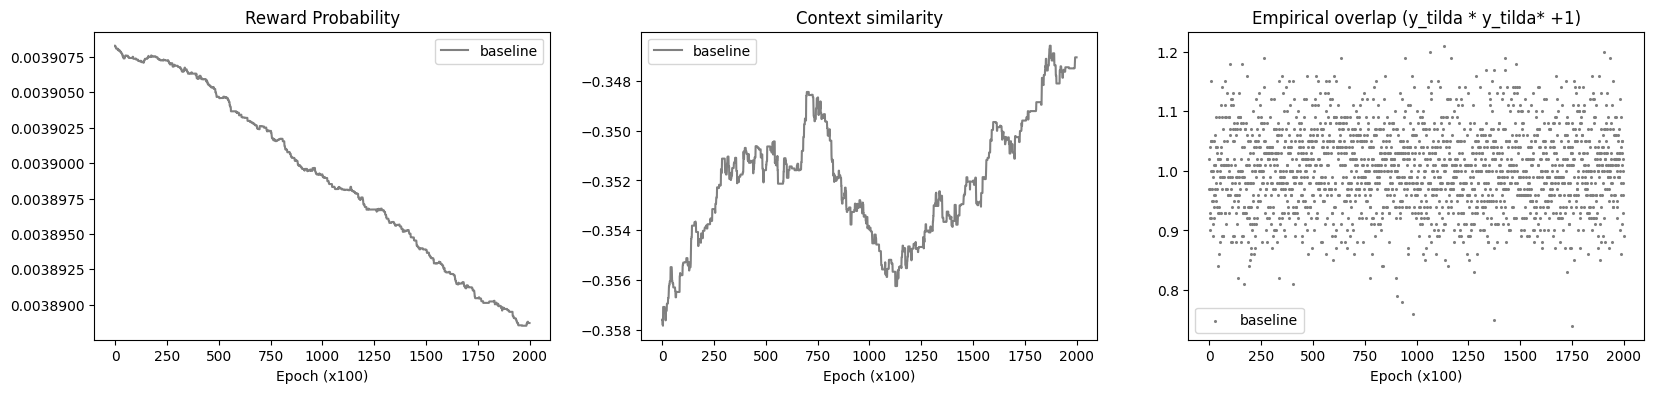

In [107]:
fig = plt.figure(figsize=(20, 4))
ax1 = plt.subplot(131)
#ax1.plot(phase1[0], label = 'pre-training phase1', c= 'r', alpha = 0.2)
ax1.plot(phase2_base[0], label = 'baseline', c= 'gray')
ax1.set_title('Reward Probability')
ax1.set_xlabel('Epoch (x100)')
#ax1.plot(np.arange(len(phase1[0]), len(phase1[0]) + len(phase2[0])),phase2[0], label = 'pre-training phase2', c= 'r')

plt.legend()
ax2 = plt.subplot(132)
#ax2.plot(phase2[-2], label = 'pre-training phase2', c = 'r')
ax2.plot(phase2_base[-2], label = 'baseline', c= 'gray')
ax2.set_title('Context similarity')
ax2.set_xlabel('Epoch (x100)')
plt.legend()

ax3 = plt.subplot(133)
#ax3.scatter(np.arange(len(phase2[-1])),phase2[-1], s= 1.5, c = 'r', label = 'pre-trianing phase2')
ax3.scatter(np.arange(len(phase2_base[-1])),phase2_base[-1], c= 'gray', label = 'baseline', s=1.5)
ax3.set_title('Empirical overlap (y_tilda * y_tilda* +1)')
ax3.set_xlabel('Epoch (x100)')
plt.legend()

In [302]:
teachers_new, students_new, teacher_cs_new, student_cs_new = initialize_nets()



In [309]:
_, perturb_base= curriculum_solve(teachers_new, students_base, \
                                           teacher_cs_new, student_cs_base, dataloader, 0,40000, False)
perturb_phase1, perturb_phase2= curriculum_solve(teachers, students, teacher_cs_new, student_cs, dataloader, 0, 40000, False)


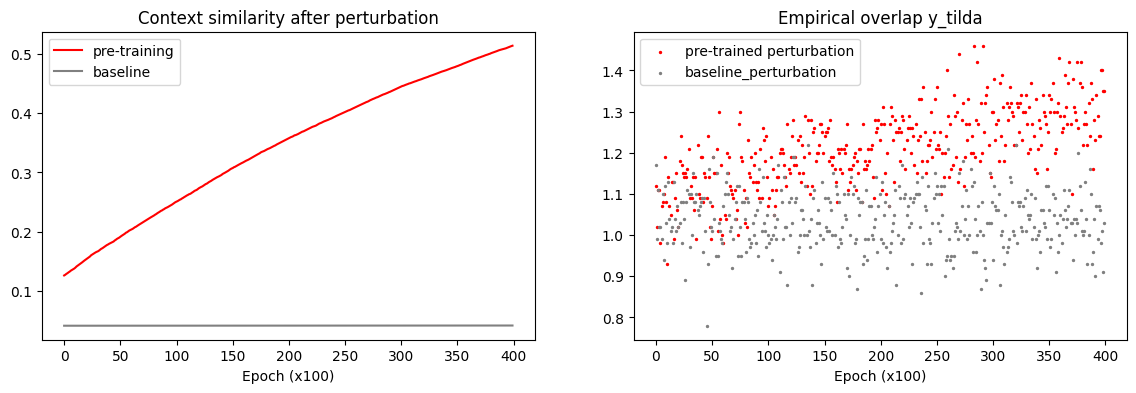

In [312]:
fig = plt.figure(figsize=(14, 4))
ax1 = plt.subplot(121)
ax1.plot(perturb_phase2[-2], label = 'pre-training', c= 'r')
ax1.plot(perturb_base[-2], label = 'baseline', c= 'gray')
ax1.set_title('Context similarity after perturbation')
ax1.set_xlabel('Epoch (x100)')
plt.legend()

ax2 = plt.subplot(122)
ax2.scatter(np.arange(len(perturb_phase2[-1])), perturb_phase2[-1], c = 'red', s = 2, label = 'pre-trained perturbation')
ax2.scatter(np.arange(len(perturb_base[-1])), perturb_base[-1], c = 'gray', s=2, label = 'baseline_perturbation')
ax2.set_xlabel('Epoch (x100)')
ax2.set_title('Empirical overlap y_tilda')
plt.legend()

In [248]:
for k in range(10):
    x_seq = torch.cat(dataloader.get_batch()['x'])
    ys = []
    ys_pred = []
    ys_sign = []
    ys_sign_pred = []
    ys_tilda = []
    ys_tilda_pred = []
    ys_tilda_sign = []
    ys_tilda_sign_pred = []
        
    for i,x in enumerate(x_seq):  
        y, y_sign= teachers[i](x)
        y_pred, y_sign_pred= students[i](x)
        ys.append(y.squeeze(-1))
        ys_pred.append(y_pred.squeeze(-1))
        ys_sign.append(y_sign)
        ys_sign_pred.append(y_sign_pred)
        
    ys=torch.stack(ys, dim=-1)
    ys_pred=torch.stack(ys_pred, dim=-1)
        
    ys_sign_pred = torch.stack(ys_sign_pred)
    ys_sign = torch.stack(ys_sign)
        
    for t in range(dataloader.seq_len[0]):
        y_tilda, y_tilda_sign = teacher_cs(ys[t][None,:])
        y_tilda_pred, y_tilda_sign_pred = student_cs(ys_pred[t][None,:])
        
        
    
        

0 0 tensor([[ -595.0103],
        [-1827.2981]], grad_fn=<MmBackward0>) tensor([[ -4.0627],
        [-21.0973]], grad_fn=<MmBackward0>)
0 1 tensor([[  718.3444],
        [-1258.0123]], grad_fn=<MmBackward0>) tensor([[ 5.5323],
        [-8.6278]], grad_fn=<MmBackward0>)
0 2 tensor([[ -29.6473],
        [-340.6227]], grad_fn=<MmBackward0>) tensor([[ 2.5608],
        [-1.0681]], grad_fn=<MmBackward0>)
0 3 tensor([[ 586.2178],
        [1324.8333]], grad_fn=<MmBackward0>) tensor([[ 9.9139],
        [14.2621]], grad_fn=<MmBackward0>)
1 0 tensor([[ -418.0821],
        [-1127.2480]], grad_fn=<MmBackward0>) tensor([[ -2.6407],
        [-16.7754]], grad_fn=<MmBackward0>)
1 1 tensor([[214.3876],
        [475.0763]], grad_fn=<MmBackward0>) tensor([[0.5248],
        [3.8164]], grad_fn=<MmBackward0>)
1 2 tensor([[2180.6316],
        [-519.1625]], grad_fn=<MmBackward0>) tensor([[19.7303],
        [-5.1830]], grad_fn=<MmBackward0>)
1 3 tensor([[-2059.2300],
        [ 1356.5670]], grad_fn=<MmBackward0>

## Context as an output of a network 

In [1]:
def initialize_nets_cs():
    D1 = 10
    D2 = 400
    context_teacher1 = network.ContinuousTeacher(input_dimension = D1, hidden_dimensions = [1], nonlinearity = 'sign', normalize=True, standardize=True)
    context_student1 = network.ContinuousStudent(input_dimension= D1, hidden_dimensions= [1], nonlinearity = 'sign', normalize = True, standardize =False)

    context_teacher2 = network.ContinuousTeacher(input_dimension = D1, hidden_dimensions = [1], nonlinearity = 'sign', normalize=True, standardize=True)
    context_student2 = network.ContinuousStudent(input_dimension= D1, hidden_dimensions= [1], nonlinearity = 'sign', normalize = True, standardize =False)

    context_teacher3 = network.ContinuousTeacher(input_dimension = D1, hidden_dimensions = [1], nonlinearity = 'sign', normalize=True, standardize=True)
    context_student3 = network.ContinuousStudent(input_dimension= D1, hidden_dimensions= [1], nonlinearity = 'sign', normalize = True, standardize =False)

    context_teacher4 = network.ContinuousTeacher(input_dimension = D1, hidden_dimensions = [1], nonlinearity = 'sign', normalize=True, standardize=True)
    context_student4 = network.ContinuousStudent(input_dimension= D1, hidden_dimensions= [1], nonlinearity = 'sign', normalize = True, standardize =False)


    teacher1 = network.ContinuousTeacher(input_dimension = D2, hidden_dimensions = [1], nonlinearity = 'sign', normalize=True, standardize=True)
    student1 = network.ContinuousStudent(input_dimension= D2, hidden_dimensions= [1], nonlinearity = 'sign', normalize = True, standardize =False)

    teacher2 = network.ContinuousTeacher(input_dimension = D2, hidden_dimensions = [1], nonlinearity = 'sign', normalize=True, standardize=True)
    student2 = network.ContinuousStudent(input_dimension= D2, hidden_dimensions= [1], nonlinearity = 'sign', normalize = True, standardize =False)

    teacher3 = network.ContinuousTeacher(input_dimension = D2, hidden_dimensions = [1], nonlinearity = 'sign', normalize=True, standardize=True)
    student3 = network.ContinuousStudent(input_dimension= D2, hidden_dimensions= [1], nonlinearity = 'sign', normalize = True, standardize =False)

    teacher4 = network.ContinuousTeacher(input_dimension = D2, hidden_dimensions = [1], nonlinearity = 'sign', normalize=True, standardize=True)
    student4 =network.ContinuousStudent(input_dimension= D2, hidden_dimensions= [1], nonlinearity = 'sign', normalize = True, standardize =False)

    
    return [teacher1, teacher2, teacher3, teacher4], [student1, student2, student3, student4],\
[context_teacher1, context_teacher2, context_teacher3, context_teacher4], [context_student1, context_student2, context_student3, context_student4]

In [12]:
dataloader = data.TransientRLTask(1, [2,2,2,2], 400, True)
dataloader2 = data.TransientRLTask(1, [2,2,2,2], 10, True)

In [13]:
def context_solve(teachers, students, teacher_cs, student_cs, data_loader, num_iter1, num_iter2, baseline=False, update=100):

    metrics1=[]
    metrics2=[]
    metrics3={i:[] for i in range(4)}
    metrics4=[]
    ps1 = {i:[] for i in range(4)}
    ps2 = {i:[] for i in range(4)}
    counts1 = 0
    counts2 = 0
    ###Learning phase 1
    for l in range(num_iter1):
        x_seq = dataloader.get_batch()['x']
        ys = []
        ys_pred = []
        ys_sign = []
        ys_sign_pred = []

        """
        Compute y and y_tilda for each input
        """
        for i, x in enumerate(x_seq):
            y, y_sign= teachers[i](x)
            y_pred, y_sign_pred= students[i](x)
            ys.append(y.squeeze(-1))
            ys_pred.append(y_pred.squeeze(-1))
            ys_sign.append(y_sign)
            ys_sign_pred.append(y_sign_pred)
            
        for i in range(4):
            if torch.all(ys_sign_pred[i] == ys_sign[i]):
                counts1 +=1
                dw = 10*1/math.sqrt(100)*ys_sign_pred[i]*x_seq[i]
                students[i].layers[0].weight.data+=dw.squeeze(dim=0).mean(dim=0)
                
        if l%update == 0:
            c = 1
            for k, (t,s) in enumerate(zip(teachers, students)):
                r = t.layers[0].weight.data @ s.layers[0].weight.data.T / 100
                q = s.layers[0].weight.data @ s.layers[0].weight.data.T / 100
                overlap = r.item()/np.sqrt(q.item())
                p = 1- 1/np.pi*np.arccos(overlap)
                c*= p**data_loader.seq_len[k]
                ps1[k].append(overlap)

            metrics1.append(c)

    ###Learning phase 2
    for l in range(num_iter2):
        x_seq = torch.cat(dataloader.get_batch()['x'])
        x_seq_c = torch.cat(dataloader2.get_batch()['x'])
        ys = []
        ys_pred = []
        ys_sign = []
        ys_sign_pred = []
        cs = []
        cs_pred = []
        ys_tilda = []
        ys_tilda_pred = []
        ys_tilda_sign = []
        ys_tilda_sign_pred = []
        
        for i,(x,x2) in enumerate(zip(x_seq, x_seq_c)):  
            y, y_sign= teachers[i](x)
            y_pred, y_sign_pred= students[i](x)
            c, _ = teacher_cs[i](x2)
            c_pred, _ = student_cs[i](x2)
            ys.append(y.squeeze(-1))
            ys_pred.append(y_pred.squeeze(-1))
            ys_sign.append(y_sign)
            ys_sign_pred.append(y_sign_pred)
            cs.append(c.squeeze(-1))
            cs_pred.append(c_pred.squeeze(-1))
            
        ys=torch.stack(ys, dim=-1)
        ys_pred=torch.stack(ys_pred, dim=-1)
        
        ys_sign_pred = torch.stack(ys_sign_pred)
        ys_sign = torch.stack(ys_sign)
        
        cs = torch.stack(cs, dim = -1)
        cs_pred = torch.stack(cs_pred, dim = -1)
        

        for t in range(dataloader.seq_len[0]):
            y_tilda = torch.sum(cs[t, :] * ys[t,:])
            y_tilda_pred = torch.sum(cs_pred[t,:]* ys_pred[t,:])
            
            ys_tilda.append(y_tilda.item())
            ys_tilda_sign.append(torch.sign(y_tilda).item())
            ys_tilda_pred.append(y_tilda_pred.item())
            ys_tilda_sign_pred.append(torch.sign(y_tilda_pred).item())
            
        
        if ys_tilda_sign == ys_tilda_sign_pred:
            counts2+=1
            for k in range(4):
                if baseline:
                    eta1 = 1
                else:
                    eta1 = 0.01
                dw = eta1/math.sqrt(400)*torch.tensor(ys_tilda_sign)*cs_pred[:,k]*x_seq[k].T
                students[k].layers[0].weight.data += dw.mean(dim=1)
                dv = 1/math.sqrt(10)*torch.tensor(ys_tilda_sign_pred)*ys_pred[:,k]*x_seq_c[k].T
                student_cs[k].layers[0].weight.data += dv.mean(dim = 1)
                
                        

        if l%update == 0:
            samples = []
            c = 1
            for k, (t,s) in enumerate(zip(teachers, students)):
                r = t.layers[0].weight.data @ s.layers[0].weight.data.T / 100
                q = s.layers[0].weight.data @ s.layers[0].weight.data.T / 100
                overlap = r.item()/np.sqrt(q.item())
                p = 1- 1/np.pi*np.arccos(overlap)
                c*= p**data_loader.seq_len[k]
                ps2[k].append(overlap)
                
            metrics2.append(c)
            
            for i in range(4):
                tc_norm = teacher_cs[i].layers[0].weight.data@teacher_cs[i].layers[0].weight.data.T
                sc_norm = student_cs[i].layers[0].weight.data@student_cs[i].layers[0].weight.data.T
                tc_sc = teacher_cs[i].layers[0].weight.data@student_cs[i].layers[0].weight.data.T
                metrics3[i].append((tc_sc/torch.sqrt(tc_norm)/torch.sqrt(sc_norm)).item())
            
            for _ in range(100):                
                x_seq = torch.cat(dataloader.get_batch()['x'])
                x_seq_c = torch.cat(dataloader2.get_batch()['x'])
                ys = []
                ys_pred = []
                ys_sign = []
                ys_sign_pred = []
                cs = []
                cs_pred = []
                ys_tilda = []
                ys_tilda_pred = []
                ys_tilda_sign = []
                ys_tilda_sign_pred = []

                for i,(x,x2) in enumerate(zip(x_seq, x_seq_c)):  
                    y, y_sign= teachers[i](x)
                    y_pred, y_sign_pred= students[i](x)
                    c, _ = teacher_cs[i](x2)
                    c_pred, _ = student_cs[i](x2)
                    ys.append(y.squeeze(-1))
                    ys_pred.append(y_pred.squeeze(-1))
                    ys_sign.append(y_sign)
                    ys_sign_pred.append(y_sign_pred)
                    cs.append(c.squeeze(-1))
                    cs_pred.append(c_pred.squeeze(-1))

                ys=torch.stack(ys, dim=-1)
                ys_pred=torch.stack(ys_pred, dim=-1)

                ys_sign_pred = torch.stack(ys_sign_pred)
                ys_sign = torch.stack(ys_sign)

                cs = torch.stack(cs, dim = -1)
                cs_pred = torch.stack(cs_pred, dim = -1)

                for t in range(dataloader.seq_len[0]):
                    y_tilda = torch.sum(cs[t, :] * ys[t,:])
                    y_tilda_pred = torch.sum(cs_pred[t,:]* ys_pred[t,:])

                    ys_tilda.append(y_tilda.item())
                    ys_tilda_sign.append(torch.sign(y_tilda).item())
                    ys_tilda_pred.append(y_tilda_pred.item())
                    ys_tilda_sign_pred.append(torch.sign(y_tilda_pred).item())

                samples.append(np.mean(
                        [ys_tilda_sign == ys_tilda_sign_pred]))

            metrics4.append(np.mean(samples))
            
                
    return (metrics1, ps1, counts1), (metrics2, ps2, counts2, metrics3, metrics4) 

In [14]:
teachers, students, teacher_cs, student_cs = initialize_nets_cs()
_, students_base, _, student_cs_base = initialize_nets_cs()



In [15]:
phase1_base, phase2_base,= context_solve(teachers, students_base, \
                                           teacher_cs, student_cs_base, dataloader, 0,20000, True)
#phase1, phase2= context_solve(teachers, students, teacher_cs, student_cs, dataloader, 20000, 20000, False)



/tmp/ipykernel_988520/964750093.py:115: RuntimeWarning: invalid value encountered in scalar divide
  overlap = r.item()/np.sqrt(q.item())


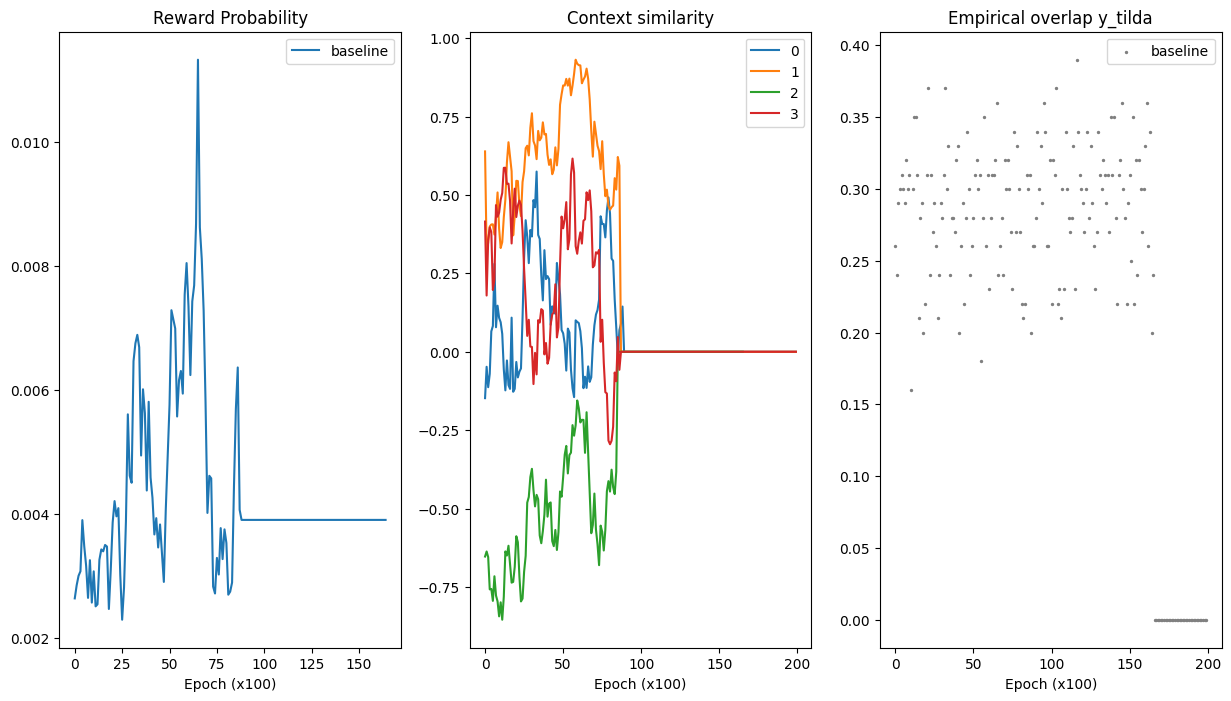

In [16]:
_base = True
_curricula = False
fig = plt.figure(figsize=(15, 8))
ax1 = plt.subplot(131)
if _curricula:
    ax1.plot(phase1[0], label = 'pre-training')
    ax1.plot(np.arange(len(phase1[0]), len(phase1[0]) + len(phase2[0])), phase2[0], label = 'after')
if _base:
    ax1.plot(phase2_base[0], label = 'baseline')
ax1.set_title('Reward Probability')
ax1.set_xlabel('Epoch (x100)')
plt.legend()

ax2 = plt.subplot(132)
if _curricula:
    for i in range(4):
        ax2.plot(phase2[-2][i], label = f'{i}')
if _base:
    for i in range(4):
        ax2.plot(phase2_base[-2][i], label = f'{i}')
ax2.set_title('Context similarity')
ax2.set_xlabel('Epoch (x100)')
plt.legend()

ax3 = plt.subplot(133)
if _curricula:
    ax3.scatter(np.arange(len(phase2[-1])), phase2[-1], c = 'red', s = 2, label = 'pre-trained ')
if _base:
    ax3.scatter(np.arange(len(phase2_base[-1])),phase2_base[-1], c = 'gray', s=2, label = 'baseline')
ax3.set_xlabel('Epoch (x100)')
ax3.set_title('Empirical overlap y_tilda')
plt.legend()

In [127]:
x=dataloader.get_batch()['x']

In [131]:
x[3]

tensor([[[ 0.2324, -0.4258,  1.3833,  0.3230, -0.1898, -1.8492, -1.7874,
           1.3985,  1.4142, -1.3491,  1.1498, -0.6303, -1.5498,  1.0896,
           1.9993,  1.1922, -0.6970, -1.0694, -0.8565,  1.2670,  0.7997,
           2.3128, -2.0854,  0.1804, -0.7401,  1.0922, -0.1330, -0.3798,
          -0.9263,  1.6365,  1.4171,  0.4648, -0.6064,  0.9871,  0.4703,
           1.0673,  1.9036,  0.6234,  1.2257, -0.5732, -2.0996,  1.8235,
          -1.3889,  0.4423, -0.1366, -1.2695,  0.0979,  1.4123, -0.6994,
           0.4182,  1.3044, -0.6761, -0.3391, -0.1714,  0.8933,  0.6398,
           0.1696, -0.5528, -0.8421, -1.1686,  0.8730,  0.2389,  0.3293,
          -1.3704,  0.9438,  0.3216,  0.0424, -1.3032, -1.3870, -0.6088,
           0.6013,  0.2501,  0.1324, -0.6292,  0.3873, -0.7427,  0.7247,
          -0.9140, -0.9560,  0.4240, -0.2694, -0.4677,  1.4231, -1.7500,
           1.5292,  2.0851,  0.7790,  1.2822, -0.7552,  0.3482,  1.0500,
           0.7486, -0.3495,  0.4981,  0.6379,  0.05